##Naive forecasting

##Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

##Trend and Seasonality

In [0]:
def trend(time, slope=0):
    return slope * time

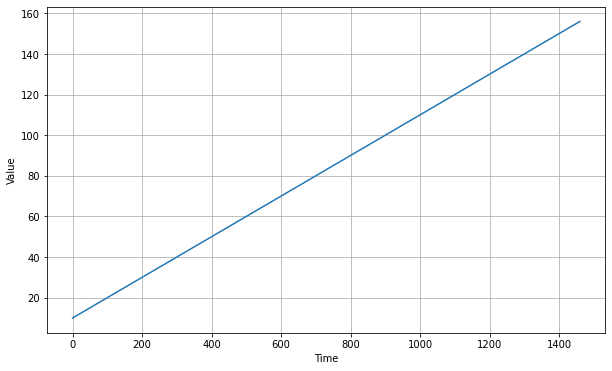

In [0]:

time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [0]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

In [0]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

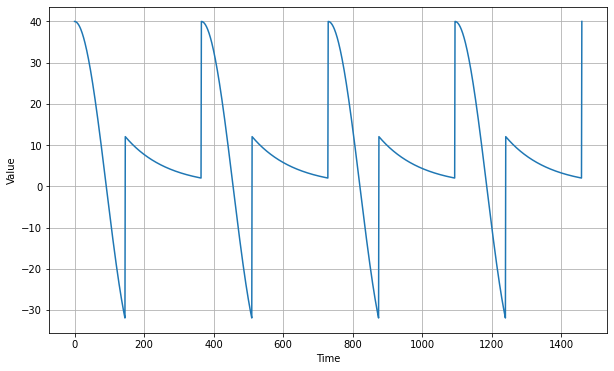

In [0]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

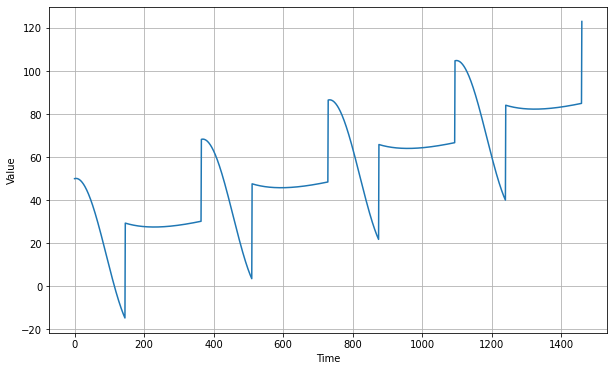

In [0]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

##Noise

In [0]:

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

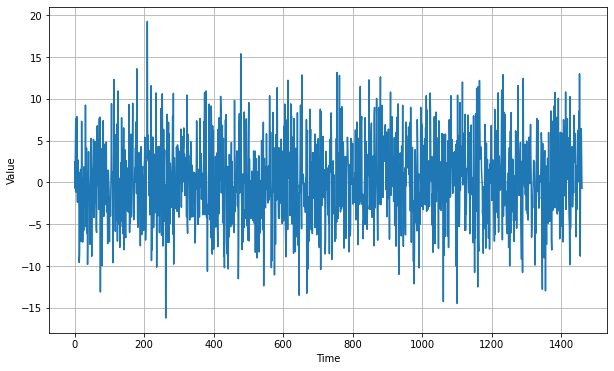

In [0]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

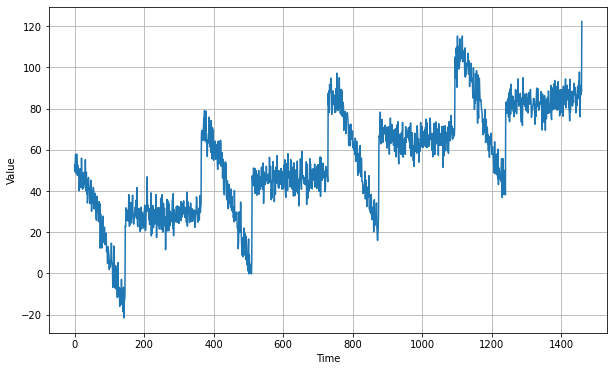

In [0]:

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

##Forecasting with Machine Learning

In [0]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

##Linear Model

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 0s 10ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - l

In [0]:
from tensorflow import keras

In [45]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 67.6867 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 52.3572 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 17.6521 - mae: 18.1484 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4604 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9201 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8785 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8191 - mae: 8.3014 - lr: 1.84

(1e-06, 0.001, 0.0, 20.0)

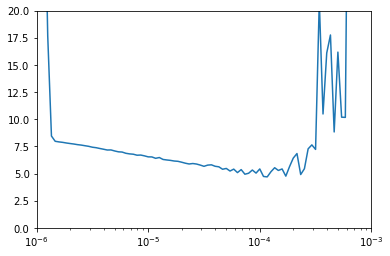

In [46]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - lo

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [51]:
lin_forecast.shape


(461,)

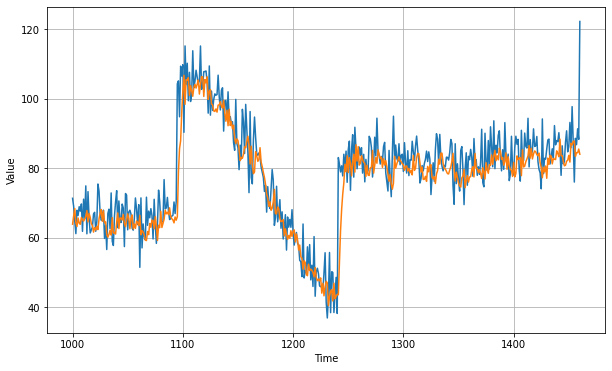

In [52]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [53]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662674

##Dense Model Forecasting

In [54]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 43.8270 - mae: 44.3262 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 41.5210 - mae: 42.0202 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.6253 - mae: 39.1248 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 35.3203 - mae: 35.8201 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 31.5905 - mae: 32.0903 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 27.4033 - mae: 27.9022 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.7830 - mae: 23.2804 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 17.7632 - mae: 18.2594 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 12.6771 - mae: 13.1682 

(1e-07, 0.005, 0.0, 30.0)

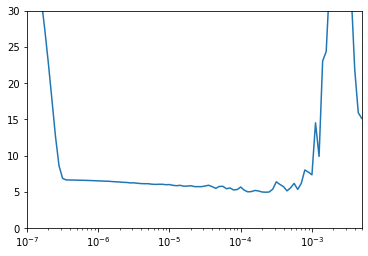

In [55]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 7ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 6.9028 

In [0]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

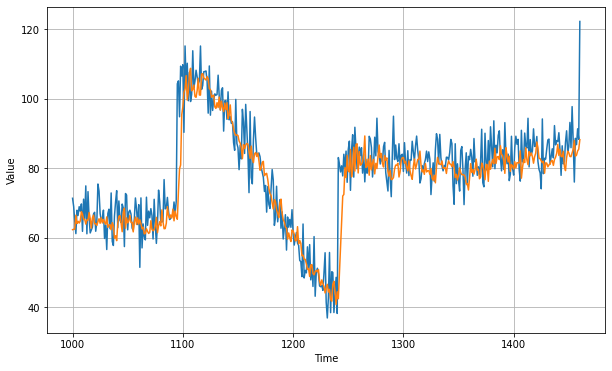

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [59]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.2025557